# Predict Test Scores of Student

* Hazael Alejandro Hinojosa Hernández

Data set *Predict Test Scores of students*

The dataset selected has the following data information:

* **school**  -	*string*	- Name of the school the student is enrolled in.
* **school_setting** -	*string*	-Location of the school (urban, suburban).
* **school_type**	- *string*	- Type of school: public or non-public.
* **classroom**	- *string*	- Type of classroom
* **teaching_method**	- *string*	- Instructional method: experimental or standard.
* **n_student	**- *integer* -	Number of students in the class.
* **student_id**	- *string*	- Unique identifier for each student.
* **gender**	- *string* -	Gender of the student: male or female.
* **lunch** - *string* -	Whether the student qualifies for free/subsidized lunch.
* **pretest**- *numeric* -	Pre-test score out of 100.
* **posttest** - *numeric* - final test score

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

Mounted at /content/drive


I chose to use a linear regression model because we want to predict the students’ scores as a numeric value. Logistic regression wouldn’t work here since it’s meant for probabilities (pass/fail). Another option could be a decision tree, but for this project I’ll stick with linear regression to keep it simple and show clear results.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/test_scores.csv')
display(data.head())
print(data.shape)

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


(2133, 11)


# Preparación del Dataset

The first step is to verify if there are any null values in the dataset. This will help decide whether they should be removed, filled, or approximated before proceeding with data manipulation.

In [ ]:
data.isnull().sum()

,0
school,0
school_setting,0
school_type,0
classroom,0
teaching_method,0
n_student,0
student_id,0
gender,0
lunch,0
pretest,0


Convert the categorical variables into dummy variables to make them suitable for analysis and modeling

In [ ]:
data_clean=data.drop(['school','school_setting','school_type', 'classroom','teaching_method', 'gender', 'lunch',"student_id"],axis=1)
#variables dummy y eliminamos una columna o opción nos quedamos con la 1 en adelante, se elimna la columna 0
dummy_school = pd.get_dummies(data["school"], prefix="school").iloc[:,1:]
dummy_school_setting = pd.get_dummies(data["school_setting"], prefix="school_setting").iloc[:,1:]
dummy_school_type = pd.get_dummies(data["school_type"], prefix="school_type").iloc[:,1:]
dummy_classroom = pd.get_dummies(data["classroom"], prefix="classroom").iloc[:,1:]
dummy_teaching_method = pd.get_dummies(data["teaching_method"], prefix="teaching_method").iloc[:,1:]
dummy_gender = pd.get_dummies(data["gender"], prefix="gender").iloc[:,1:]
dummy_lunch = pd.get_dummies(data["lunch"], prefix="lunch").iloc[:,1:]
data_clean = data_clean.join([dummy_school,dummy_school_setting, dummy_school_type, dummy_classroom,dummy_teaching_method, dummy_gender, dummy_lunch])
data_clean=data_clean.drop(["posttest"],axis=1)
data_clean= data_clean.join(data["posttest"])
data_clean.head()

,n_student,pretest,school_CCAAW,school_CIMBB,school_CUQAM,school_DNQDD,school_FBUMG,school_GJJHK,school_GOKXL,school_GOOBU,...,classroom_XZM,classroom_YTB,classroom_YUC,classroom_ZBH,classroom_ZDT,classroom_ZNS,teaching_method_Standard,gender_Male,lunch_Qualifies for reduced/free lunch,posttest
0,20.0,62.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,72.0
1,20.0,66.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,79.0
2,20.0,64.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,76.0
3,20.0,61.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,77.0
4,20.0,64.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,76.0


Due to the large number of columns generated, a correlation matrix will be created to identify and keep only the features with the highest correlation for building the model.

In [ ]:
pd.set_option('display.max_rows', None) #para poder observar todas las variables y su correlacion no solo las primeras y ultimas
correlation_matrix = data_clean.corr()
cor_target = correlation_matrix["posttest"].sort_values(ascending=False)
print(cor_target)

posttest                                  1.000000
pretest                                   0.950884
school_setting_Suburban                   0.454704
school_UKPGS                              0.434771
school_IDGFP                              0.308953
classroom_9AW                             0.202935
classroom_P2A                             0.200691
classroom_08N                             0.190788
school_ZMNYA                              0.189678
school_CCAAW                              0.182682
classroom_98D                             0.177884
school_UUUQX                              0.176066
classroom_V77                             0.171611
classroom_PGH                             0.169015
classroom_IPU                             0.165587
classroom_XXE                             0.156214
classroom_KXB                             0.150697
school_CIMBB                              0.133454
school_FBUMG                              0.122164
classroom_H7S                  

Based on the correlation matrix, the top 10 features with the highest correlation will be chosen as predictor variables, along with the target variable

In [ ]:
pd.reset_option('display.max_rows')
predictors = data_clean[["pretest","school_setting_Suburban", "school_UKPGS","school_IDGFP", "classroom_9AW", "classroom_P2A","classroom_08N", "school_ZMNYA","school_CCAAW", "classroom_98D"]]
target = data_clean["posttest"]
y=target
x=predictors
display(x.head())
display(y.head())


,pretest,school_setting_Suburban,school_UKPGS,school_IDGFP,classroom_9AW,classroom_P2A,classroom_08N,school_ZMNYA,school_CCAAW,classroom_98D
0,62.0,False,False,False,False,False,False,False,False,False
1,66.0,False,False,False,False,False,False,False,False,False
2,64.0,False,False,False,False,False,False,False,False,False
3,61.0,False,False,False,False,False,False,False,False,False
4,64.0,False,False,False,False,False,False,False,False,False


,posttest
0,72.0
1,79.0
2,76.0
3,77.0
4,76.0


# Prediction model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(f"conjuntos de prueba {x_test.shape}")
print(f"conjuntos de entrenamiento {x_train.shape}")

conjuntos de prueba (640, 10)
conjuntos de entrenamiento (1493, 10)


In [ ]:
lm = LinearRegression()
lm.fit(x_train, y_train)
print(f"Intercepto: {lm.intercept_}")
print(f"Coeficientes: {lm.coef_}")

Intercepto: 14.750225274288553
Coeficientes: [ 0.94636261 -0.30055067  4.16427016 -0.22062055 -4.60467272  3.53404286
 -3.93096136  2.85419188  2.74294439  5.89031236]


#Validate the model and confirm the choice of using simple linear regression for this dataset

In [ ]:
R2_train = lm.score(x_train, y_train)
R2_test = lm.score(x_test, y_test)

print(f"oeficiente de determinación R^2 en entrenamiento: {R2_train:.3f}")
print(f"oeficiente de determinación R^2 en testing: {R2_test:.3f}")

oeficiente de determinación R^2 en entrenamiento: 0.915
oeficiente de determinación R^2 en testing: 0.895


In [ ]:
y_pred = lm.predict(x_test)
SSD = np.sum((y_test - y_pred)**2)
RSE = np.sqrt(SSD / (len(y_test) - x_test.shape[1]-1))
Rat=RSE/y_test.mean()
print(f"RSE: {RSE}")
print(f"RSE%: {Rat} %")

RSE: 4.428923514570031
RSE%: 0.06565927841845773 %


In [ ]:
#quiero observar como son los datos que predice el modelo y compararlos con los verdaderos
y_pred = lm.predict(x)
new_table = pd.DataFrame({"student_id":data["student_id"],"posttest_real": data_clean["posttest"],"posttest_predicho": np.round(y_pred).astype(int)}) #np.round(y_pred).astype(int) para redondear al entero dado que asi son las calificaciones
new_table

,student_id,posttest_real,posttest_predicho
0,2FHT3,72.0,73
1,3JIVH,79.0,77
2,3XOWE,76.0,75
3,556O0,77.0,72
4,74LOE,76.0,75
...,...,...,...
2128,T8LSK,55.0,52
2129,VNP26,46.0,51
2130,YDR1Z,51.0,57
2131,YUEIH,53.0,58


After obtaining the initial estimation and determination coefficients, cross-validation was applied to check whether the model heavily depends on the data distribution or if it is more stable.

In [ ]:
cv = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(lm, x, y, scoring='r2', cv=cv)
score_mean = scores.mean()
Errors = 1-scores
Error = Errors.mean()
print("R^2 en cada fold:", scores)
print("R^2 promedio (cross-validation):", score_mean)
print("Error promedio (cross-validation):", Error)

R^2 en cada fold: [0.92470257 0.89022983 0.92143098 0.89845394 0.88323842 0.91136635
 0.90722174 0.9136812  0.91545297 0.90724433]
R^2 promedio (cross-validation): 0.9073022326324427
Error promedio (cross-validation): 0.09269776736755726


The cross-validation results show that the model is quite stable, as there is no significant variance between the R² values across folds. This also indicates that the model is not strongly dependent on the data distribution, and the overall R² score is good (though not excellent). Based on these findings, the built model can be considered a solid and reliable one.

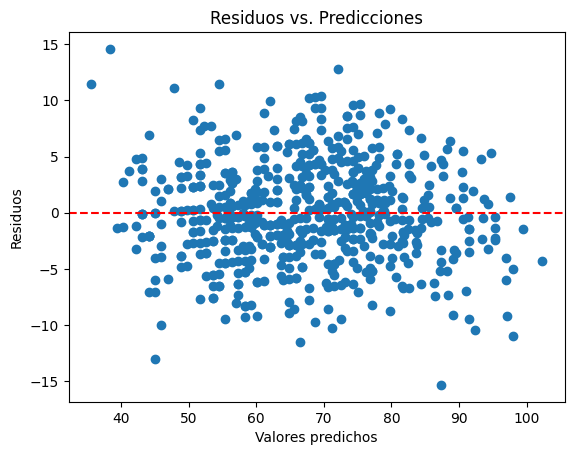

In [ ]:
residuos = y_test - lm.predict(x_test)
plt.scatter(lm.predict(x_test), residuos)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuos vs. Predicciones")
plt.xlabel("Valores predichos")
plt.ylabel("Residuos")
plt.show()

A predicted values vs. residuals plot was created to visually evaluate the model. Some outliers can be observed since the fit is not perfect, but most of the results fall within a ±7.5 range. While this margin is not entirely satisfactory given that scores are on a 0–100 scale, it is important to highlight that the residuals are uniformly distributed. This means the model does not show bias toward systematically underestimating or overestimating results, which is a positive characteristic.

Additionally, higher-degree linear regression was tested to see if the fit could be improved.

In [ ]:
def regression_validation(X_data, Y, Y_pred):
    SSD = np.sum((Y - Y_pred) ** 2)
    RSE = np.sqrt(SSD / (len(X_data) - 1))
    y_mean = np.mean(Y)
    RSE_rate = RSE / y_mean
    print("SSD = ", SSD)
    print("RSE = ", RSE)
    print("RSE_% = ", RSE_rate)
    return

for d in range(2, 7):
    poly = PolynomialFeatures(degree=d)
    X_data_poly = poly.fit_transform(x_train)
    lm = LinearRegression()
    lm.fit(X_data_poly, y_train)
    print(f"Regresión de grado: {d}")
    print("R^2 entrenamiento = ", lm.score(X_data_poly, y_train))
    print("R^2 testing = ", lm.score(poly.fit_transform(x_test), y_test))
    print("alpha = ", lm.intercept_)  # Intercepto
    print("beta_i = ", lm.coef_)  # Coeficientes
    y_pred = lm.predict(X_data_poly)
    regression_validation(X_data_poly, y_train, y_pred)
    print("\n")

Regresión de grado: 2
R^2 entrenamiento =  0.9193053224047807
R^2 testing =  0.9008268149317838
alpha =  21.359502314225793
beta_i =  [ 3.27949606e-11  6.29530604e-01  4.24553029e+00  2.46645114e+01
  1.95079444e+01  1.05133525e-01  1.41349927e+01 -3.64237213e+00
 -1.66805263e+00  6.63160444e+00 -1.66454705e+00  3.54251597e-03
 -1.57602668e-01 -9.21467262e-01 -5.78607923e-01  1.97652739e-02
 -4.02045120e-01  2.08509640e-01  1.20733751e-01 -2.60054657e-01
  1.65430000e-01  4.24553029e+00  2.46645114e+01  0.00000000e+00
  1.05133525e-01  0.00000000e+00 -3.64237213e+00 -1.66805263e+00
  6.63160444e+00  0.00000000e+00  2.46645114e+01  0.00000000e+00
  1.05133525e-01  0.00000000e+00 -3.64237213e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.95079444e+01  0.00000000e+00
  1.41349927e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.66454705e+00  1.05133525e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.41349927e+01
  0.00000000e+00  0.0

When testing polynomial regressions of degrees 2 to 6, no significant improvement was observed compared to the simple linear regression. The differences in $R^2$ values between training and testing remained minimal, and the increase in explanatory power was only about 0.1 to 0.2 over the original simple regression. Given this marginal gain and the added complexity, it was concluded that the simple linear regression model is the most appropriate choice.